In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import pickle, time, os

# Dataset generation - Stage 1.  Word Selection

This notebook represents the very first step in our data generation pipeline. Since our goal is to create a dataset that is gender-invariant and free of gender co-occurring words, we will have to make sure that the words we use to bootstrap the generation of our dataset are, themselves, abiding by the properties we defined. In particular, we want to make sure that the words selected by our procedure satisfy the following property:

$-\epsilon \leq \texttt{PMI}(w, \texttt{"she"}) - \texttt{PMI}(w, \texttt{"he"}) \leq \epsilon $, where $w$ is a word in the vocabulary and $\epsilon$ is a limit on how much skewed a word can be towards one of the gendered words. As detailed in the paper, we set $\epsilon = 0.263$.



The notebook is organized as follows:
1. Read the co-occurrence counts from PILE as well as the term-frequencies, as collected by [Razeghi et al (2022)](https://aclanthology.org/2022.emnlp-demos.39/).
2. Preprocess the list of words to remove non-English words.
3. Preprocess the remaining words and remove rare words (e.g., words in the 20% percentile).
4. Compute the $\texttt{PMIDiff}(w) = \texttt{PMI}(w, \texttt{"she"}) - \texttt{PMI}(w, \texttt{"he"})$ value for every word $w$
5. Sample a subset centered around the origin by sampling words that satisfy  $ -\epsilon \leq \texttt{PMIDiff}(w) \leq \epsilon$

In [2]:
# Base directory where to find the files
DATA_DIR = "/extra/ucinlp1/cbelem/bias-dataset-project"

## 1. Load term counts

In [3]:
def read_pkl_file(fp: str):
    """Wrapper to read pickled filepath."""
    print("Reading file at", fp)
    start = time.time()
    with open(fp, 'rb') as tff:
        data = pickle.load(tff)
    end = time.time()
    print(f"Time to read file {(end-start)/60:.2f} min")
    return data


def read_original_coccurrence_files(parent_dir: str) -> dict: # 5GB
    """Wrapper to read the co-occurrence term count files from parent_dir."""
    return read_pkl_file(f"{parent_dir}/all_co_words.pkl")


def read_original_tf_files(parent_dir) -> dict: # 16M
    """Wrapper to read the term-frequency file from parent_dir."""
    return read_pkl_file(f"{parent_dir}/term_frequency.pkl")


def read_pmi_diff(filepath: str) -> pd.DataFrame: #1.9M
    """Read precomputed PMI difference file"""
    # Read the PMI difference filepath
    pmi_diff = {"word": [], "pmi_diff": []}
    with open(filepath, "rt") as f:
        for row in f:
            word, _, val = row.rpartition(",")
            pmi_diff["word"].append(word)
            pmi_diff["pmi_diff"].append(float(val))
    return pd.DataFrame(pmi_diff).sort_values("pmi_diff").reset_index(drop=True)

In [4]:
# Easier to lookup for word -> term frequency
TERM_COUNTS_DICT = read_original_tf_files(DATA_DIR)
TERM_COUNTS_TOTAL = sum(TERM_COUNTS_DICT.values())
# Convert term counts into dataframe to add more metadata
TERM_COUNTS_DF = pd.DataFrame(TERM_COUNTS_DICT.items(), columns=["word", "counts"])

total_counts = sum(TERM_COUNTS_DICT.values())

# Add a relative frequency column
TERM_COUNTS_DF["freq"] = TERM_COUNTS_DF["counts"].apply(lambda x: x / total_counts)
TERM_COUNTS_DF.head(5)

Reading file at /extra/ucinlp1/cbelem/bias-dataset-project/term_frequency.pkl
Time to read file 0.00 min


,word,counts,freq
0,-,8547638016,0.065901
1,*,2911636063,0.022448
2,=,2693603408,0.020767
3,/,1842700323,0.014207
4,2,696181955,0.005367


## Preprocessing data

**Keeping English Alphabet words:**
In this section, we wish to exclude numbers, punctuation, non-english words from the list of words. Therefore, a first preprocessing step we do is to exclude any word that is not fully created based on the English alphabet. We use Python's default functionality `str.isalpha` to achieve this.

In [5]:
# Determine whether the words belong to the english alphabet or not
TERM_COUNTS_DF['isalpha'] = TERM_COUNTS_DF["word"].apply(str.isalpha)

english_alphabet = TERM_COUNTS_DF["isalpha"].value_counts()[True]
print(f'{english_alphabet/len(TERM_COUNTS_DF):.2%} of the examples',
      f'(out of {len(TERM_COUNTS_DF)}) belong to the English alphabet.')

# Drop words containing non-English alphabet characters
TERM_COUNTS_DF = TERM_COUNTS_DF[TERM_COUNTS_DF["isalpha"]]
TERM_COUNTS_DF[TERM_COUNTS_DF["isalpha"]].tail(10)

74.34% of the examples (out of 770874) belong to the English alphabet.


,word,counts,freq,isalpha
770857,subjectivization,2070,1.595946e-08,True
770858,qtilde,2070,1.595946e-08,True
770859,flavanoid,2070,1.595946e-08,True
770860,tedisco,2070,1.595946e-08,True
770861,schimperi,2070,1.595946e-08,True
770865,yhw,2070,1.595946e-08,True
770866,qopt,2070,1.595946e-08,True
770867,echaban,2070,1.595946e-08,True
770870,sulina,2070,1.595946e-08,True
770873,fritzy,2070,1.595946e-08,True


**Removing non-English words**: However, restricting to the English alphabet does not exclude other languages. For example, the spanish word "echaban" would be kept if we only applied the previous procedure. One hypothesis would be to remove the non-English words, using a language detector. However, this may also remove borrowed foreign words that are common in the English language, like _influenza_. 

Therefore, in the following cells, we will use a heuristic approach that keeps a word in `TERM_COUNTS_DF` if one of the following conditions is satisfied:

1. The [fasttext](https://fasttext.cc/docs/en/unsupervised-tutorial.html) character-level language classifier predicts the word language to be English word with at least `ENGLISH_PRED_THRESHOLD`% confidence.
2. There exists a sense definition for word $w$ in [WordNet](https://wordnet.princeton.edu/).


Note: We experimented with [langdetect](https://pypi.org/project/langdetect/) library from Google as well, but it performs poorly when identifying individual words, e.g., mentions that _hello_ is not English. Leading to a large number of false negatives (i.e., claiming English words are non-English words). On the other hand, fasttext proved to be much better at this task. Besides, it also gives the confidence associated with the prediction.

In [6]:
try:
    import fasttext
except:
    # Install fasttext
    !pip install fasttext
    import fasttext
from typing import List, Tuple 

    
FTEXT_MODEL_NAME = "lid.176.bin"
# Download the language detection model (trained w/ 176 languages)
if not os.path.isfile(FTEXT_MODEL_NAME):
    !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
        
# Load fasttext model
FTEXT_MODEL = fasttext.load_model(FTEXT_MODEL_NAME)

# Language threshold
ENGLISH_PRED_THRESHOLD = 0.6

In [7]:
def fasttext_predict(word: str, model):
    """Predicts the language using the specified fasttext model."""
    pred = model.predict(word, k=1)
    return pred[0][0].replace("__label__", ""), pred[1][0]


# Determine whether words are english
TERM_COUNTS_DF["ft_pred_lang"], TERM_COUNTS_DF["ft_pred_conf"] = zip(
    *TERM_COUNTS_DF["word"].apply(fasttext_predict, model=FTEXT_MODEL)
)
pred_eng_counts = TERM_COUNTS_DF["ft_pred_lang"].value_counts()["en"]
print(f'{pred_eng_counts/len(TERM_COUNTS_DF):.2%} of the words are predicted to be English')
print(f'Number of unique predicted languages: {TERM_COUNTS_DF["ft_pred_lang"].nunique()}')
TERM_COUNTS_DF["ft_pred_lang"].value_counts()

41.03% of the words are predicted to be English
Number of unique predicted languages: 176


ft_pred_lang
en     235132
de      39083
fr      36183
it      33114
es      30462
        ...  
rue         2
sc          2
av          1
mai         1
dty         1
Name: count, Length: 176, dtype: int64

In [8]:
from nltk.corpus import wordnet

# Count the number of wordnet senses
TERM_COUNTS_DF["wordnet_counts"] = TERM_COUNTS_DF["word"].apply(lambda x: len(wordnet.synsets(x)))
(TERM_COUNTS_DF["wordnet_counts"].value_counts() / len(TERM_COUNTS_DF)).head(10)

wordnet_counts
0    0.836202
1    0.086968
2    0.034485
3    0.016211
4    0.008566
5    0.005259
6    0.003246
7    0.002385
8    0.001419
9    0.001085
Name: count, dtype: float64

In [9]:
def english_words_mask(df: pd.DataFrame, threshold) -> pd.DataFrame:
    is_english = (df["ft_pred_lang"] == "en") & (df["ft_pred_conf"] > threshold)
    is_in_wordnet = (is_english == False) & (df["wordnet_counts"] > 0)
    return (is_english | is_in_wordnet)


IS_ENGLISH_MASK = english_words_mask(TERM_COUNTS_DF, ENGLISH_PRED_THRESHOLD)

nonengl_terms_orig_pmi = TERM_COUNTS_DF[~IS_ENGLISH_MASK].sort_values("word")
print("Total number of non english words:", len(nonengl_terms_orig_pmi))

print("Examples of words dropped due to being dubbed not english according to our procedure...")
print("-", "\n- ".join(nonengl_terms_orig_pmi["word"].values[::2000]))

TERM_COUNTS_DF = TERM_COUNTS_DF[IS_ENGLISH_MASK]
len(TERM_COUNTS_DF)

Total number of non english words: 422635
Examples of words dropped due to being dubbed not english according to our procedure...
- aaaa
- accountrepository
- addrows
- afsnit
- akinci
- allelements
- amerigas
- angkasa
- anumit
- aquarian
- arrc
- assignedto
- aufgenommen
- avicularia
- bahcall
- bartosz
- beechey
- bergey
- biase
- birkoff
- bmpria
- botos
- brindado
- buildactionmask
- børnene
- canalys
- casciano
- celebrazione
- chaotique
- chiều
- cisi
- cmpresult
- comaroff
- condotto
- contextptr
- cosechas
- creveld
- cuihao
- códice
- databse
- deciziilor
- demnach
- despido
- dichos
- dischord
- doces
- doublevector
- dtsq
- décevoir
- edendada
- eisemann
- emercoin
- ennen
- erasistratus
- espanola
- euroqol
- expérimentations
- farcry
- fermor
- finanzen
- flug
- forståelse
- frii
- fva
- ganji
- gelsolin
- getaverage
- ghazzali
- globales
- gosselin
- grindr
- gurmukh
- halid
- hastie
- hellyer
- hhz
- hoffmaster
- hrig
- hyperimmune
- identificado
- ilumina
- incorrecta


150424

## Preprocess: Remove rare words

Upon observation of the remaining words, we observe that some of the words in the list (e.g., "succinylacetone", "clientage") correspond to valid English words and, sometimes, typos. Since these words do not represent common English words, it could throw off our model during dataset generation (e.g., degrade generation, lack diversity). 

To account for this, we notice that these words are often rarer and occur less frequently in the dataset. As such, we decided to remove them.

/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

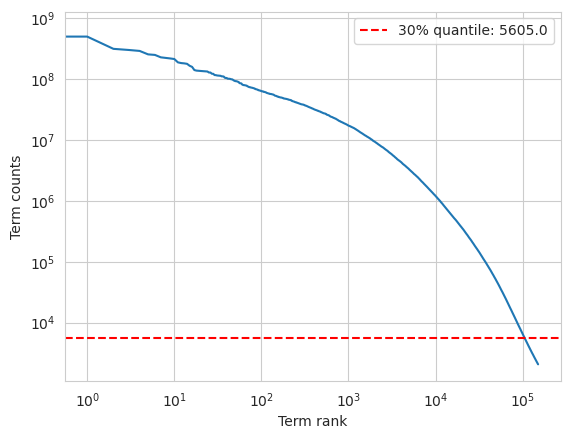

In [10]:
# Plot the term counts vs rank of english words
sns.lineplot(x=np.arange(len(TERM_COUNTS_DF)), y=TERM_COUNTS_DF["counts"].values)
plt.xscale("log"); plt.xlabel("Term rank")
plt.yscale("log"); plt.ylabel("Term counts")

q = 0.3
q_val = TERM_COUNTS_DF["counts"].quantile(q)
plt.axhline(q_val, label=f"{q:.0%} quantile: {q_val}", ls="--", c="r")
plt.legend()
plt.show()

In [11]:
low_freq_terms_alpha = TERM_COUNTS_DF[TERM_COUNTS_DF["counts"] < q_val].sort_values("counts", ascending=False)
print("Total number of low freq words:", len(low_freq_terms_alpha))

print("Examples of words with higher rank (lower frequency):")
print("-", "\n- ".join(low_freq_terms_alpha["word"].values[::2000]))

Total number of low freq words: 45121
Examples of words with higher rank (lower frequency):
- girds
- challengeable
- signalization
- suburbans
- denslow
- balloonists
- charbroiled
- yters
- sallisaw
- coffy
- defibrillated
- shaddoll
- safex
- spangly
- cornewall
- eigendirections
- mpda
- tectona
- influenzas
- flathub
- nonkeratinized
- ogromnym
- spaning


In [12]:
TERM_COUNTS_DF = TERM_COUNTS_DF[TERM_COUNTS_DF["counts"] > q_val]
TERM_COUNTS_DF.tail(20)

,word,counts,freq,isalpha,ft_pred_lang,ft_pred_conf,wordnet_counts
376680,distributively,5610,4.325245e-08,True,en,0.778595,2
376699,networkmode,5610,4.325245e-08,True,en,0.724172,0
376747,cutline,5608,4.323703e-08,True,en,0.845637,0
376750,jham,5608,4.323703e-08,True,en,0.717699,0
376754,mismanage,5608,4.323703e-08,True,es,0.328606,1
376759,imro,5608,4.323703e-08,True,en,0.947572,0
376770,oneill,5608,4.323703e-08,True,en,0.646695,0
376771,minelaying,5608,4.323703e-08,True,en,0.799603,1
376774,driveinfo,5608,4.323703e-08,True,en,0.816889,0
376776,buccally,5608,4.323703e-08,True,en,0.725402,0


`TERM_COUNTS_DF` contains the information about a good estimate the English terms that are likely to occur in the data. A few limitations that we should address in the future are:

1. remove slang (e.g., making use of [SlangNet](https://aclanthology.org/L16-1686/), [SlangSD](http://liangwu.me/slangsd/), etc.
2. remove names
3. remove abbreviations


For now, we will proceed, assuming this is the best subset of the English words we can derive from PILE.

## Computing the PMI for each word

In this section, we will compute the $\texttt{PMIDiff}(w)$ for every word $w$. To that end, we will first define a list of gendered words (eg, "mother", "father", "boy", "girl") and we will compute the $\texttt{PMI}$ of every word and these _group words_. Note that the co-occurrence counts loaded in `TERMS_CO_OCCUR`, consist of counts within a window size 10 after stop words have been removed. These do not refer to co-occurrence counts within the same document. 

$$\texttt{PMI}(w, g) = log \frac{p(w, g)}{p(w)p(g)}$$, where $w$ is the word in the vocabullary and $g$ is a group word. PMI therefore represents the strength of association between the two words, namely, how likely are the two words to co-occur together when compared to appearing individually. A negative value indicates that the words are less likely to co-occur together, whereas a positive value implies that the words almost always appear together.


In [14]:
from collections import defaultdict

In [23]:
# This document is huge
TERMS_CO_OCCUR = read_original_coccurrence_files(DATA_DIR)
print("Number of bigrams:", len(TERMS_CO_OCCUR))
TERMS_CO_OCCUR_TOTAL = sum(TERMS_CO_OCCUR.values()) # 131M


GROUP_TERMS = [
    ("she", "he"),
    ("her", "his"),
    ("her", "him"),
    ("hers", "his"),
    ("herself", "himself"),
    ("grandmother", "grandfather"),
    ("grandma", "grandpa"),
    ("stepmother", "stepfather"),
    ("stepmom", "stepdad"),
    ("mother", "father"),
    ("mom", "dad"),
    ("aunt", "uncle"),
    ("aunts", "uncles"),
    ("mummy", "daddy"),
    ("sister", "brother"),
    ("sisters", "brothers"),
    ("daughter", "son"),
    ("daughters", "sons"),
    ("female", "male"),
    ("females", "males"),
    ("feminine", "masculine"),
    ("woman", "man"),
    ("women", "men"),
    ("madam", "sir"),
    ("matriarchy", "patriarchy"),
    ("girl", "boy"),
    ("lass", "lad"),
    ("girls", "boys"),
    ("girlfriend", "boyfriend"),
    ("girlfriends", "boyfriends"),
    ("wife", "husband"),
    ("wives", "husbands"),
    ("queen", "king"),
    ("queens", "kings"),
    ("princess", "prince"),
    ("princesses", "princes"),
    ("lady", "lord"),
    ("ladies", "lords"),
]
FEMALE_TERMS, MALE_TERMS = zip(*GROUP_TERMS)

ALL_TERMS = set(TERM_COUNTS_DF.word.values)
ALL_TERMS.add(FEMALE_TERMS)
ALL_TERMS.add(MALE_TERMS)

# Since we're interested in computing the PMI value for every word and other K words
# we will have to iterate it at least k times (which would be time consuming)
# Therefore, we will filter out the structure to include only pairs where terms defined in 
# `terms` or group words appear.
def select_subset(bigram_counts: dict, terms: set) -> dict:
    results = {}
    for bigram, counts in bigram_counts.items():
        if bigram[0] in terms or bigram[1] in terms:
            results[bigram] = counts       
    return results


# Update term counts dict to contain only the relevant terms
TERM_COUNTS_DICT = {w: v for w, v in TERM_COUNTS_DICT.items() if w in ALL_TERMS}
len(TERM_COUNTS_DICT), len(TERM_COUNTS_DF)

# Update terms co-occurs
TERMS_CO_OCCUR = select_subset(TERMS_CO_OCCUR, ALL_TERMS)
print("Reduced number of bigrams:", len(TERMS_CO_OCCUR)) # roughly 113M pairs remaining

Reading file at /extra/ucinlp1/cbelem/bias-dataset-project/all_co_words.pkl
Time to read file 1.18 min
Number of bigrams: 131889277
Reduced number of bigrams: 113310272


In [43]:
def compute_pmi(unigram_counts: dict, bigram_counts: dict, w, g, unigram_total: int, bigram_total: int):
    """Compute PMI for a words w, g using the bigram and unigram counts structures."""
    p_w = unigram_counts.get(w, 0) / unigram_total
    p_g = unigram_counts.get(g, 0) / unigram_total
    
    p_w_g = bigram_counts.get((w, g), 0) + bigram_counts.get((g, w), 0) / bigram_total
    
    if 0 in (p_w, p_g, p_w_g):
        return None
    
    # For numerical stability, we opt for computing PMI as:
    return np.log(p_w_g) - np.log(p_w) - np.log(p_g)


def compute_pmi_per_group_word(words: List[str], group_words: List[str]):
    results = defaultdict(list)
    for group_word in set(group_words):
        for word in words:
            pmi = compute_pmi(
                unigram_counts=TERM_COUNTS_DICT,
                bigram_counts=TERMS_CO_OCCUR,
                w=word, g=group_word,
                unigram_total=TERM_COUNTS_TOTAL, 
                bigram_total=TERMS_CO_OCCUR_TOTAL)
            
            results[f"pmi_{group_word}"].append(pmi)
            
    return results

In [44]:
# Compute the PMI between every word and every female word
PMI_FEMALE = compute_pmi_per_group_word(TERM_COUNTS_DF["word"].values.tolist(), FEMALE_TERMS)

# Compute the PMI between every word and every male word
PMI_MALE = compute_pmi_per_group_word(TERM_COUNTS_DF["word"].values.tolist(), MALE_TERMS)

In [45]:
len(PMI_FEMALE), len(PMI_MALE)

(37, 37)

### Computing the PMI difference:

To obtain a sense of how much more likely is a word to co-occur with female words than with male words, we can compute the difference of PMIs as follows:

$$\texttt{PMIDiff}(w, g_F, g_M) = \texttt{PMI}(w, g_F) - \texttt{PMI}(w, g_M)$$, where $g_M$ and $g_F$ represent male and female gendered words, respectively.

In the original versions of this work, we simply determined the gendered co-occurrence of a word by computing $\texttt{PMIDiff}(w, \texttt{"she"}, \texttt{"he"})$. However, this may be suboptimal since many other words can be implicitly correlated with gender. 

In this notebook, we will compute the PMI difference as the $max_{(g_F, g_M) \in (G_F, G_M)} |\texttt{PMIDiff}(w, g_F, g_M)|$, where $(G_F, G_M)$ is the list of paired group words (eg, as defined in `GROUP_TERMS`). The intuition is that we will represent the gender polarity of a word with the strongest existing correlation. 

In [61]:
import math 

# Every word w, we have len(GROUP_TERMS) PMI values
# - some of which can be None, if one of the grouped words did not occur with w)
results = defaultdict(list)
results["word"] = TERM_COUNTS_DF["word"].values.tolist()

for word_idx in range(len(TERM_COUNTS_DF)):
    for fterm, mterm in GROUP_TERMS:
        pmi_f = PMI_FEMALE[f"pmi_{fterm}"][word_idx]
        pmi_m = PMI_MALE[f"pmi_{mterm}"][word_idx]
        
        # If one of the terms is not defined, append None
        if pmi_f is None or pmi_m is None or math.isnan(pmi_f) or math.isnan(pmi_m):
            results[f"pmi_{fterm}_{mterm}"].append(None)
        else:
            results[f"pmi_{fterm}_{mterm}"].append(pmi_f - pmi_m)
            
            
results = pd.DataFrame(results)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105296 entries, 0 to 105295
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   word                         105296 non-null  object 
 1   pmi_she_he                   54302 non-null   float64
 2   pmi_her_his                  58880 non-null   float64
 3   pmi_her_him                  51824 non-null   float64
 4   pmi_hers_his                 0 non-null       object 
 5   pmi_herself_himself          0 non-null       object 
 6   pmi_grandmother_grandfather  5870 non-null    float64
 7   pmi_grandma_grandpa          1022 non-null    float64
 8   pmi_stepmother_stepfather    1002 non-null    float64
 9   pmi_stepmom_stepdad          0 non-null       object 
 10  pmi_mother_father            24598 non-null   float64
 11  pmi_mom_dad                  8761 non-null    float64
 12  pmi_aunt_uncle               5173 non-null    float64
 13 

,word,pmi_she_he,pmi_her_his,pmi_her_him,pmi_hers_his,pmi_herself_himself,pmi_grandmother_grandfather,pmi_grandma_grandpa,pmi_stepmother_stepfather,pmi_stepmom_stepdad,...,pmi_girlfriend_boyfriend,pmi_girlfriends_boyfriends,pmi_wife_husband,pmi_wives_husbands,pmi_queen_king,pmi_queens_kings,pmi_princess_prince,pmi_princesses_princes,pmi_lady_lord,pmi_ladies_lords
0,he,-0.265558,-0.865963,-0.722650,None,None,-0.608781,-0.879060,-0.591373,None,...,0.382008,0.768178,0.703848,0.993050,-0.915364,-0.925902,-0.255627,-0.464170,0.958814,0.488122
1,his,24.393786,-26.205727,-0.867249,None,None,-0.558500,-0.471417,-0.327862,None,...,1.934905,1.380073,2.387322,2.297434,-0.663874,-0.654000,-0.573947,-0.729233,0.711715,-0.203620
2,her,27.794594,1.082642,0.779209,None,None,0.778857,0.849701,0.135938,None,...,-1.720319,-0.387546,-2.343299,-1.324431,1.592257,0.375076,1.338525,0.692578,2.248230,1.420042
3,she,27.227379,2.534845,0.903386,None,None,1.173369,1.235702,0.532250,None,...,-0.500973,-0.623451,25.219580,25.431784,1.655895,0.731248,1.563366,1.240706,2.309701,1.388678
4,time,-0.018094,-0.075418,-0.024359,None,None,-0.032290,0.138998,-0.094809,None,...,0.102838,0.189910,25.979100,25.974651,-0.229606,-0.575594,0.405374,0.184908,1.479240,0.666625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105291,umbilicate,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105292,dfes,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105293,jasminum,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105294,preventives,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ORIG_PMI_DF = read_pmi_diff("../data/pmi-diffs-gender.txt")
ORIG_PMI_DF.head()

In [ ]:
ORIG_PMI_DF = ORIG_PMI_DF.set_index("word").join(TERM_COUNTS_DF.set_index("word"), how="left")
ORIG_PMI_DF = ORIG_PMI_DF.reset_index()
ORIG_PMI_DF.drop("word", axis=1).corr("kendall")

In [ ]:
sns.jointplot(ORIG_PMI_DF, y="freq", x="pmi_diff", s=5, alpha=0.5)
plt.yscale("log")

### Drop uncommon words

In [ ]:
# Mark the most common words
ORIG_PMI_DF["is_common"] = ORIG_PMI_DF["word"].isin(TERM_COUNTS_DF_ALPHA_UQ["word"].values)
ORIG_PMI_DF["is_common"].value_counts()

In [ ]:
low_freq_terms_orig_pmi = ORIG_PMI_DF[ORIG_PMI_DF["is_common"] == False].sort_values("word")
print("Total number of low freq words:", len(low_freq_terms_orig_pmi))

print("Examples of words dropped due to lower frequency:")
print("-", "\n- ".join(low_freq_terms_orig_pmi["word"].values))

In [ ]:
plt.figure(figsize=(4, 3), dpi=200)
sns.histplot(ORIG_PMI_DF, x="pmi_diff", hue="is_common")

In [ ]:
ORIG_PMI_DF_UQ = ORIG_PMI_DF[ORIG_PMI_DF["is_common"]].reset_index(drop=True)
print(len(ORIG_PMI_DF), "-->", len(ORIG_PMI_DF_UQ), "; delta =", len(ORIG_PMI_DF)-len(ORIG_PMI_DF_UQ))
ORIG_PMI_DF_UQ.head()

In [ ]:
ORIG_PMI_DF_UQ.drop("word", axis=1).corr("kendall")

In [ ]:
ORIG_PMI_DF_UQ_LANG[mask].sort_values("word").head()

In [ ]:
ORIG_PMI_DF_UQ_ENG = ORIG_PMI_DF_UQ_LANG[mask]
ORIG_PMI_DF_UQ_ENG

In [ ]:
sns.jointplot(ORIG_PMI_DF_UQ_LANG, x="pred_conf", y="wordnet_counts", hue="is_english", s=5)

In [ ]:
sns.jointplot(ORIG_PMI_DF_UQ_LANG, x="pred_conf", y="wordnet_counts", hue="is_english", s=5)

In [ ]:
sns.jointplot(ORIG_PMI_DF_UQ_ENG, x="pred_conf", y="pmi_diff", hue="is_english", s=5)

In [ ]:
plt.figure(figsize=(4, 3), dpi=200)
sns.jointplot(ORIG_PMI_DF_UQ_ENG, x="wordnet_counts", y="pmi_diff", s=5)
plt.xlabel("Number of WordNet definitions")
plt.ylabel("PMI Difference, $\delta(w)$")
plt.show()

In [ ]:
TERM_COUNTS_DF.shape

In [ ]:
ORIG_PMI_DF_UQ_ENG.shape[0], TERM_COUNTS_DF.shape[0], round(ORIG_PMI_DF_UQ_ENG.shape[0] / TERM_COUNTS_DF.shape[0], 4)

### Obtain the words

In the variable ORIG_PMI_DF_UQ_ENG, we have the selected English words.
We have yet to reduce the set of words to the ones having the same root.
Since we're using stratified sampling to select one word from each bin, we do not need to care too much about this. If two words with the same root are selected, it is likely that it is because they were sampled from different bins. In which case, it may suggest that there is a significant difference.

In [ ]:
num_bins = 20
# define PMI range
pmi_diff_max = ORIG_PMI_DF_UQ_ENG["pmi_diff"].apply(np.abs).describe()["max"]
print(pmi_diff_max)

pmi_diff_max = np.ceil(pmi_diff_max)
bins = np.linspace(-pmi_diff_max, pmi_diff_max, num_bins)

ORIG_PMI_DF_UQ_ENG.loc[:,"pmi_diff_bins"] = pd.cut(ORIG_PMI_DF_UQ_ENG["pmi_diff"], bins)
ORIG_PMI_DF_UQ_ENG["pmi_diff_bins"].value_counts()

In [ ]:
intervals = sorted(ORIG_PMI_DF_UQ_ENG["pmi_diff_bins"].unique())
interval_idx_middle = [ix for ix, interval in enumerate(intervals) if 0 in interval][0]
intervals[interval_idx_middle]

In [ ]:
sampling_bin = ORIG_PMI_DF_UQ_ENG[ORIG_PMI_DF_UQ_ENG["pmi_diff_bins"] == intervals[interval_idx_middle]]
sampling_bin = sampling_bin.sort_values("freq", ascending=False)
sampling_bin.head(30)

In [ ]:
sampling_bin.tail(30)

In [ ]:
sampling_bin.sort_values("pmi_diff").head(30)

In [ ]:
sampling_bin.sort_values("pmi_diff").tail(30)

In [ ]:
ORIG_PMI_DF_UQ_ENG["skews"] = ["male"] * len(ORIG_PMI_DF_UQ_ENG)
female_mask = ORIG_PMI_DF_UQ_ENG["pmi_diff"] > 0
ORIG_PMI_DF_UQ_ENG.loc[female_mask, "skews"] = "female"

neutral_mask = (ORIG_PMI_DF_UQ_ENG["pmi_diff"] >= -0.263) & (ORIG_PMI_DF_UQ_ENG["pmi_diff"] <= 0.263)
ORIG_PMI_DF_UQ_ENG.loc[neutral_mask, "skews"] = "neutral"

ORIG_PMI_DF_UQ_ENG["skews"].value_counts() / len(ORIG_PMI_DF_UQ_ENG)

In [ ]:
ORIG_PMI_DF_UQ_ENG.sample()

In [ ]:
def get_wordnet_info(df: pd.DataFrame):
    results = []
    for ix, row in df.iterrows():
        wordnet_defs = {}
        
        if row["wordnet_counts"] > 0:
            synsets = wordnet.synsets(row["word"])
            wordnet_defs = {s.name(): s.definition() for s in synsets}
            
        results.append(wordnet_defs)
        
    return results


wordnet_sample = get_wordnet_info(ORIG_PMI_DF_UQ_ENG)
ORIG_PMI_DF_UQ_ENG["wordnet_definitions"] = wordnet_sample

In [ ]:
ORIG_PMI_DF_UQ_ENG.to_csv("../results__pool_of_words_by_pmi.csv", index=None)

In [ ]:
ORIG_PMI_DF_UQ_ENG_NEUTRAL = ORIG_PMI_DF_UQ_ENG[ORIG_PMI_DF_UQ_ENG["skews"] == "neutral"].copy()
ORIG_PMI_DF_UQ_ENG_NEUTRAL.to_csv("../results__neutral__pool_of_words_by_pmi.csv", index=None)
len(ORIG_PMI_DF_UQ_ENG_NEUTRAL)

In [ ]:
import os
BASE_DIR = ""
SAMPLES = []
for i, seed in enumerate((9123, 19223, 8172361, 91283, 72613)):
    sample = ORIG_PMI_DF_UQ_ENG_NEUTRAL.sample(n=100, replace=False, random_state=seed)
    
    for num in (5, 10, 20):
        os.makedirs(f"../results-words{num}/words{i+1}", exist_ok=True)
        sample.to_csv(f"../results-words{num}/words{i+1}/selected_words__{seed}.csv")
        words = sorted(sample["word"].unique())

        with open(f"../results-words{num}/words{i+1}/words.txt", "w") as f:
            f.write("\n".join(words))

In [ ]:
sample = ORIG_PMI_DF_UQ_ENG.groupby('pmi_diff_bins', group_keys=False).apply(lambda x: x.sample(frac=0.005))
sample["skews"].value_counts() / len(sample)

In [ ]:
sample["pmi_diff_bins"].value_counts() / len(sample)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(ORIG_PMI_DF_UQ_ENG, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Original: {len(ORIG_PMI_DF_UQ_ENG)}", stat="probability")
sns.histplot(sample, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Sample: {len(sample)}", stat="probability")
plt.legend()

In [ ]:
sample2 = ORIG_PMI_DF_UQ_ENG.groupby('pmi_diff_bins', group_keys=False).apply(lambda x: x.sample(min(len(x), 10), replace=False))
sample2["skews"].value_counts() / len(sample2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(ORIG_PMI_DF_UQ_ENG, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Original: {len(ORIG_PMI_DF_UQ_ENG)}", stat="probability")
sns.histplot(sample2, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Sample: {len(sample2)}", stat="probability")
plt.legend()
sample2["pmi_diff_bins"].value_counts() / len(sample2)

#### add wordnet info

In [ ]:
sorted(sample2.word)

### Persist

In [ ]:
sample.to_csv("../results/selected_words.csv", index=None)

In [ ]:
TERM_COUNTS_DICT["he"],TERM_COUNTS_DICT["his"], TERM_COUNTS_DICT["him"]

In [ ]:
TERM_COUNTS_DICT["she"], TERM_COUNTS_DICT["her"]

In this file, we plan to select a set of words from the pretraining set in an automatic fashion. We'll try to make an intuitive choice by considering the following:
 
 $$\text{PMI}(w, \text{"she"}) - \text{PMI}(w, \text{"he"}) = log \frac{P(\text{"she"}|w)}{P(\text{"he"}|w)}$$

Thus, we will deem words whose odd ratio is 2.5 times smaller or larger to be unproprortionally skewed. We will not consider these words for our bias benchmark creation:
- Remove words whose $\frac{P(\text{"she"}|w)}{P(\text{"he"}|w)} \geq \tau \vee \frac{P(\text{"he"}|w)}{P(\text{"she"}|w)} \geq \tau$, where $\tau = 2.5$


## Check original words frequency


In [ ]:
orig_df = pd.read_csv("../../experiments-tacl-june-2023/data/pmi_diffs_selected.csv")
# orig_df = orig_df[~orig_df["selected"].isna()]

orig_words_set = set(orig_df["word"].unique())
orig_df["is_common"] = orig_df["word"].isin(TERM_COUNTS_DF_ALPHA_UQ["word"].values)
orig_df["is_common"].value_counts()

In [ ]:
sns.lineplot(x=np.arange(len(TERM_COUNTS_DF_ALPHA)), y=TERM_COUNTS_DF_ALPHA["counts"].values)

idx = np.array(TERM_COUNTS_DF_ALPHA[TERM_COUNTS_DF_ALPHA["word"].isin(orig_df["word"])].index)
sns.scatterplot(x=idx, y=TERM_COUNTS_DF_ALPHA["counts"].values[idx], color="red", s=15)
plt.xscale("log"); plt.xlabel("Term rank")
plt.yscale("log"); plt.ylabel("Term counts")

q = 0.2
q_val = TERM_COUNTS_DF_ALPHA["counts"].quantile(q)
plt.axhline(q_val, label=f"{q:.0%} quantile: {q_val}", ls="--", c="r")
plt.legend()
plt.show()

In [ ]:
current_df = pd.read_csv("../../experiments-aug-2023/results/selected_words.csv")
current_df

In [ ]:
sns.lineplot(x=np.arange(len(TERM_COUNTS_DF_ALPHA)), y=TERM_COUNTS_DF_ALPHA["counts"].values)

idx = np.array(TERM_COUNTS_DF_ALPHA[TERM_COUNTS_DF_ALPHA["word"].isin(current_df["word"])].index)
sns.scatterplot(x=idx, y=TERM_COUNTS_DF_ALPHA["counts"].values[idx], color="black", s=15)
plt.xscale("log"); plt.xlabel("Term rank")
plt.yscale("log"); plt.ylabel("Term counts")

q = 0.2
q_val = TERM_COUNTS_DF_ALPHA["counts"].quantile(q)
plt.axhline(q_val, label=f"{q:.0%} quantile: {q_val}", ls="--", c="r")
plt.legend()
plt.show()

In [ ]:
ORIG_PMI_DF_UQ_ENG.sort_values("counts", ascending=False).head(30)

## Originally picked words

In [74]:
orig_words = pd.concat((
    pd.read_csv("../results-words5/words1/selected_words__9123.csv", index_col=0),
    pd.read_csv("../results-words5/words2/selected_words__19223.csv", index_col=0),
    pd.read_csv("../results-words5/words3/selected_words__8172361.csv", index_col=0),
    pd.read_csv("../results-words5/words4/selected_words__91283.csv", index_col=0),
    pd.read_csv("../results-words5/words5/selected_words__72613.csv", index_col=0),
)).drop_duplicates()
print(len(orig_words))

493


In [88]:
orig_words.to_csv("selected_words.csv")




In [63]:
q_val

5605.0

In [ ]:
orig_words[orig_words.word == "whatcha"]

In [ ]:
TERM_COUNTS_DF[TERM_COUNTS_DF["wordnet_counts"] >= 1]

In [ ]:
orig_words[orig_words.word.isin(["votary", "wale", "waylaid", "waylay", "ween", "spasmodic"])]